#Risk Matrix (Impact vs. Likelihood)

___
## Step 0: Definitions and support functions
---
######@Script  [Run the script below]

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display  # Import HTML from IPython.display

# Define the version variable
version = 1  # Change this to 2 to use the second set of levels

if version == 1:
    # Version 1: Basic impact and likelihood levels
    impact_levels = ["Low", "Medium", "High"]
    impact_levels_grade = [impact_levels.index(level)+1 for level in impact_levels]
    likelihood_levels = ["Low", "Medium", "High"]
    likelihood_levels_grade = [likelihood_levels.index(level)+1 for level in likelihood_levels]

elif version == 2:
    # Version 2: Updated impact and likelihood levels
    impact_levels = ["Insignificant", "Minor", "Moderate", "Major", "Catastrophic"]
    impact_levels_grade = [i + 1 for i in range(len(impact_levels))]  # Grade from 1 to 5
    likelihood_levels = ["Almost certain", "Likely", "Possible", "Unlikely", "Rare"]
    likelihood_levels = ["Rare", "Unlikely", "Possible", "Likely","Almost certain"]
    likelihood_levels_grade = [i + 1 for i in range(len(likelihood_levels))]  # Grade from 1 to 5

from matplotlib.colors import ListedColormap

priority_levels = [
    (4,'🔴 Critical', 'Immediate action required.', 'red'),
    (3,'🟠 High', 'Needs proactive management.', 'orange'),
    (2,'🟡 Moderate', 'Manageable but requires attention.', 'yellow'),
    (1,'🟢 Low', 'Long-term improvement measure.', 'green')]


priority_levels_grade = []
priority_levels_color = []
for level in priority_levels:
  priority_levels_grade.append(level[0])
  priority_levels_color.append(level[3])
priority_levels_color_reversed = priority_levels_color.reverse()
unique_risk_scores = sorted(list(set([i * j for i in impact_levels_grade for j in likelihood_levels_grade])))

table_mapping = []
min_score = min(unique_risk_scores)
max_score = max(unique_risk_scores)
num_priority_levels = len(priority_levels)

# Normalize risk scores
normalized_risk_scores = [(score - min_score) / (max_score - min_score) for score in unique_risk_scores]
# Normalize priority levels grades
normalized_priority_levels_grade = [(grade - min(priority_levels_grade)) / (max(priority_levels_grade) - min(priority_levels_grade)) for grade in priority_levels_grade]

for i, score in enumerate(unique_risk_scores):
    # Find the closest priority level
    closest_priority_index = min(range(len(normalized_priority_levels_grade)), key=lambda j: abs(normalized_risk_scores[i] - normalized_priority_levels_grade[j]))
    table_mapping.append((score, priority_levels[closest_priority_index][1], priority_levels_color[closest_priority_index]))  # Include color



# Create the matrix
matrix = np.zeros((len(impact_levels), len(likelihood_levels)), dtype=int)  # Change dtype to int
matrix_text = np.empty((len(impact_levels), len(likelihood_levels)), dtype=object)  # To store text
color_matrix = np.empty((len(impact_levels), len(likelihood_levels)), dtype=object)  # To store colors


for i, impact in enumerate(impact_levels):
    for j, likelihood in enumerate(likelihood_levels):
        risk_score = impact_levels_grade[i] * likelihood_levels_grade[j]
        for score, priority, color in table_mapping: # unpack the three values and ignore the color using _
            if risk_score == score:
                # Get the priority level grade instead of the string
                priority_level_grade = next((level[0] for level in priority_levels if level[1] == priority), None)
                priority_level_grade_text = next((level[1] for level in priority_levels if level[1] == priority), None)
                # Extract the right part after splitting by "  "

                matrix[i, j] = priority_level_grade
                matrix_text[i, j] = priority_level_grade_text
                color_matrix[i, j] = color  # Store the corresponding color
                break

# Remove the first two characters from each element
matrix_text_basic = np.array([[text[2:] for text in row] for row in matrix_text])


# Create a custom colormap
custom_cmap = ListedColormap(priority_levels_color)


import matplotlib.pyplot as plt
import numpy as np

def plot_risk_matrix(matrix, matrix_text, impact_levels, likelihood_levels, custom_cmap):
    """
    Plots a risk matrix.

    Parameters:
    - matrix: 2D array of numerical values representing the risk scores.
    - matrix_text: 2D array of text labels to display in the matrix.
    - impact_levels: List of impact levels for the y-axis.
    - likelihood_levels: List of likelihood levels for the x-axis.
    - custom_cmap: Colormap to use for the matrix.
    """

    if version == 1:
        fig, ax = plt.subplots()
    elif version == 2:
        fig, ax = plt.subplots(figsize=(12, 8))  # Width: 12 inches, Height: 8 inches

    # Display the matrix
    im = ax.imshow(matrix, cmap=custom_cmap, vmin=1, vmax=len(np.unique(matrix)))  # Set vmin and vmax based on your data range

    # Add labels
    ax.set_xticks(np.arange(len(likelihood_levels)))
    ax.set_yticks(np.arange(len(impact_levels)))
    ax.set_xticklabels(likelihood_levels)
    ax.set_yticklabels(impact_levels)

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(impact_levels)):
        for j in range(len(likelihood_levels)):
            # Determine the text color based on the background color
            bg_color = custom_cmap(matrix[i, j])  # Get the background color
            text_color = 'white' if np.mean(bg_color[:3]) < 0.5 else 'black'  # Use brightness to determine text color
            text = ax.text(j, i, matrix_text[i, j], ha="center", va="center", color=text_color)

    # Invert the y-axis to have 'Low' at the bottom and 'High' at the top
    ax.invert_yaxis()

    ax.set_title("Risk Matrix")
    ax.set_xlabel("Likelihood")
    ax.set_ylabel("Impact")
    fig.tight_layout()
    plt.show()
    return


# Create a list of dictionaries for the DataFrame
data = []
for i in range(len(impact_levels)):
    for j in range(len(likelihood_levels)):
        data.append({
            'Impact': impact_levels[i],
            'Likelihood': likelihood_levels[j],
            'Priority Level': matrix[i, j],
            'Priority Level Category': matrix_text[i, j]
        })

# Create the DataFrame
df_sorted = pd.DataFrame(data).sort_values(by='Priority Level', ascending=False)  # Order the DataFrame by 'Priority Level'
df_filtered = df_sorted[['Impact', 'Likelihood', 'Priority Level Category']]  # Select only the desired columns


def display_processed_matrix(df):
    """
    Executes the AHP analysis based on the provided criteria matrix.
    """
    # Function to format values
    def format_value(val):
        if pd.isna(val):
            return ""  # Display as an empty string for NaN values
        if isinstance(val, (int, float)):
            # Check if the value is equal to its integer representation
            if val == int(val):
                return f"{int(val)}"  # Display as integer (no decimals)
            else:
                return f"{val:.1f}"  # Display with one decimal for floats
        return val  # Return the value as is if it's neither

    # Apply the formatting function to the DataFrame
    # formatted_df = df.map(format_value)
    formatted_df = df
    # Style the DataFrame
    styled_df = formatted_df.style.set_properties(**{'text-align': 'center'})

    # Set table styles for headers and values
    styled_df = styled_df.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold'), ('border', '1px solid black')]},  # Left align headers, make them bold, and add borders
        {'selector': 'td', 'props': [('text-align', 'left'), ('border', '1px solid black')]},   # Center align values and add borders  /center
        {'selector': 'td:first-child', 'props': [('text-align', 'left'), ('border', '1px solid black')]},  # Left align the first column (criteria) and add borders
        {'selector': 'tr:hover td', 'props': [('background-color', '#f5f5f5')]},  # Optional: Highlight on hover
    ])

    # Display the styled DataFrame
    display(styled_df)
    print("\n")

#Prepare the dictionary risk_matrix
risk_matrix = {}
for index, row in df_sorted.iterrows():
    impact = row['Impact']
    likelihood = row['Likelihood']
    priority_category = row['Priority Level Category']
    # Find the corresponding description in priority_levels
    description = next((level[2] for level in priority_levels if level[1] == priority_category), None)
    # priority_grade = row['Priority Level']
    # Calculate priority_grade
    impact_level_grade = impact_levels_grade[impact_levels.index(impact)]
    likelihood_level_grade = likelihood_levels_grade[likelihood_levels.index(likelihood)]
    priority_grade = impact_level_grade * likelihood_level_grade
    risk_matrix[(impact, likelihood)] = (priority_category, description, priority_grade)

# risk_matrix

##Display Matrix

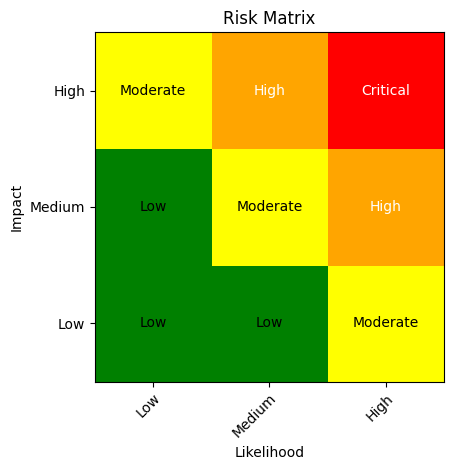


Risk Matrix:



Impact,Likelihood,Priority Level Category
High,High,🔴 Critical
Medium,High,🟠 High
High,Medium,🟠 High
Low,High,🟡 Moderate
Medium,Medium,🟡 Moderate
High,Low,🟡 Moderate
Low,Low,🟢 Low
Low,Medium,🟢 Low
Medium,Low,🟢 Low


In [29]:
# Call the function to plot
plot_risk_matrix(matrix, matrix_text_basic, impact_levels, likelihood_levels, custom_cmap)
print("\nRisk Matrix:\n")
# Display the DataFrame
df_html = df_filtered.to_html(index=False)  # Convert DataFrame to HTML
display(HTML(f"<div style='display: flex;'><div style='flex: 1;'>{df_html}</div></div>"))


.
___
## Step 1: Input Impact and Likelihood
---
######@Script  [Run the script below]

In [30]:
def determine_priority_and_action(impact, likelihood):
    """Determines the priority level and recommended action based on impact and likelihood."""
    # Get impact and likelihood grades
    impact_level_grade = impact_levels_grade[impact_levels.index(impact)]
    likelihood_level_grade = likelihood_levels_grade[likelihood_levels.index(likelihood)]

    # Calculate priority grade
    priority_grade = impact_level_grade * likelihood_level_grade

    # Determine priority category and action based on priority grade and table_mapping
    for score, priority_category, color in table_mapping:  # Iterate through table_mapping
        if priority_grade == score:
            # Find the corresponding description in priority_levels
            description = next((level[2] for level in priority_levels if level[1] == priority_category), None)
            return priority_category, description, priority_grade  # Return priority level, description, and priority grade

    # Handle cases where priority grade doesn't match any in table_mapping (shouldn't happen normally)
    return "Unknown", "Unknown", priority_grade  # Return "Unknown" if not found

def get_risk_data(input_type='user'):
    """Gets risk data from user input or returns default data."""
    if input_type == 'default':
        return [
            ["Strategic Misalignment", "Delays decision-making, misalignment across units.", "High", "High"],
            ["Financial Instability", "Restructuring costs require financial planning.", "High", "Medium"],
            ["Employee Resistance", "Cultural resistance may slow adoption.", "Medium", "High"],
            ["Operational Disruptions", "Temporary inefficiencies during restructuring.", "Medium", "Medium"],
            ["Cultural Disruption", "Addressable through leadership engagement.", "Low", "Medium"]
        ]
    else:
        num_risks = int(input("Enter the number of risks identified: "))
        risk_data = []
        for i in range(num_risks):
            risk_description = input(f"\nEnter description for Risk {i+1}: ")
            justification = input(f"Enter justification for Risk {i+1}: ")
            impact = ""
            while impact not in impact_levels:
                impact = input(f"Enter impact for Risk {i+1} ({', '.join(impact_levels)}): ").capitalize()
            likelihood = ""
            while likelihood not in likelihood_levels:
                likelihood = input(f"Enter likelihood for Risk {i+1} ({', '.join(likelihood_levels)}): ").capitalize()
            risk_data.append([risk_description, justification, impact, likelihood])
        return risk_data

# risk_data = get_risk_data(input_type='default')
# risk_data

##Input Risks, Impact, and Likelihood

In [32]:
# Get risk data
# risk_data = get_risk_data(input_type='default')
risk_data = get_risk_data()
# Create a Pandas DataFrame
columns = ["Risk Description", "Justification", "Impact", "Likelihood", "Priority Level", "Action"]
df = pd.DataFrame(risk_data, columns=columns[:-2])
# Calculate priority level and action
df["Priority Level"] = df.apply(lambda row: determine_priority_and_action(row["Impact"], row["Likelihood"])[0], axis=1)
df["Action"] = df.apply(lambda row: determine_priority_and_action(row["Impact"], row["Likelihood"])[1], axis=1)
df["priority_grade"] = df.apply(lambda row: determine_priority_and_action(row["Impact"], row["Likelihood"])[2], axis=1)

# Convert "Priority Level" column to categorical with the correct order
priority_order = [level[1] for level in priority_levels] # Extract priority labels from priority_levels
df['Priority Level'] = pd.Categorical(df['Priority Level'], categories=priority_order, ordered=True)
df = df.sort_values(by='priority_grade', ascending=False) # Sort by 'Priority Level' in descending order
# del df["priority_grade"]

display(HTML("<h2>Risk Matrix </h2>"))
# display(criteria_matrix)
display_processed_matrix(df.drop(columns=['priority_grade'], errors='ignore'))


,Risk Description,Justification,Impact,Likelihood,Priority Level,Action
0,Strategic Misalignment,"Delays decision-making, misalignment across units.",High,High,🔴 Critical,Immediate action required.
1,Financial Instability,Restructuring costs require financial planning.,High,Medium,🟠 High,Needs proactive management.
2,Employee Resistance,Cultural resistance may slow adoption.,Medium,High,🟠 High,Needs proactive management.
3,Operational Disruptions,Temporary inefficiencies during restructuring.,Medium,Medium,🟡 Moderate,Manageable but requires attention.
4,Cultural Disruption,Addressable through leadership engagement.,Low,Medium,🟢 Low,Long-term improvement measure.


---

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1T1ukfToijxkjbd2zjLnfEZajl7-psgT3AigYJ6mGxNk#gid=0
